# Blue or Red

The objective of this project is to create a Blue-or-Red (Democrat or Republican) classifier of tweets. This will be trained on approximately 650,000 tweets, downloaded from all members of Congress with a twitter handle. A latter phase of the project would be to see if the classifier could be extended to tweets in general (as opposed to just members of Congress).

In [96]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [97]:
from fastai.text import *

In [98]:
sys.path.append("/home/cdaniels")
from ai_utilities import *

## Gathering the data

The list of twitter handles was obtained here: https://github.com/unitedstates/congress-legislators/. In particular, I used the csv format: https://theunitedstates.io/congress-legislators/legislators-current.csv I created a smaller csv file `legislators-with-twitter.csv `, which included the attributes of `twitter` and `party` for each member of congress.

There were several python modules for Twitter, I choose tweepy: http://www.tweepy.org. It seemed fairly broadly used and is actively developed.

In order to gather the tweets, I needed to set up a developer account with Twitter in order to use their api. This was free. (Setting this up is described here https://developer.twitter.com and in other on-line resources.) I then created an App for this project and obtained the following keys/tokens: `consumer_key`, `consumer_secret`, `access_token`, `access_token_secret`. These are required in order to use the Twitter api to access tweets. 

It should be noted that even with these developer keys, there are restrictions to downloading tweets, including throttling the downloads. (Be sure to set the `tweepy.API`parameters `wait_on_rate_limit=True` and `wait_on_rate_limit_notify=True`)

The most time intensive part of the data preparation was downloading the tweets. Here is the code that I used, though I ran it as a script. It reads the `legislators-with-twitter.csv` file and downloads the last 100 pages of tweets for each member of congress. (A page is a Twitter construct containing roughly 20-25 tweets.) The tweets for each member of congress were saved to separate csv files. Each file contains these attributes: `handle`, `time`, `party` and `text`. Each of these file were saved in the `data` directory.

In [4]:
# usage: ipython tweets.py
# C. Bryan Daniels

# import tweepy, sys, csv
# import pandas as pd
# from pathlib import Path


# auth = tweepy.OAuthHandler('consumer_key', 'consumer_secret')
# auth.set_access_token('access_token', 'access_token_secret')

# api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# def tweets_to_csv(handle, party, pages=1, data_dir = 'data'):
#        path = Path.cwd()/data_dir
#        with open(f"{path}/{handle}.csv", 'w') as f:
#            writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#            writer.writerow(['handle','time', 'party', 'text'])
#            for p in range(pages):
#                try:
#                        tweets =[[t.created_at, t.text] for t in api.user_timeline(handle, page=p) if not     #                                  t.retweeted and ('RT @' not in t.text)]
#                        for tw in tweets:
#                            time, text = tw
#                            writer.writerow([handle, time, party, text])
#                except Exception:
#                        continue
#        print(f"finished: {handle}.csv")
#        return len(tweets)
#
# if __name__ == '__main__':
#        file = 'legislators-with-twitter.csv'
#        pages = 100
#        lg = pd.read_csv(file)
#        for handle, party in lg[['twitter','party']].to_numpy():
#                tweets_to_csv(handle, party, pages)

In [112]:
path = Path.cwd()
path.ls()

[PosixPath('/home/cdaniels/projects/blue-or-red/data'),
 PosixPath('/home/cdaniels/projects/blue-or-red/blue-or-red-small.ipynb'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_tiny.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_full_3'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_single'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_banks'),
 PosixPath('/home/cdaniels/projects/blue-or-red/house_ideology.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/senate_ideology.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/export.pkl'),
 PosixPath('/home/cdaniels/projects/blue-or-red/tweets_of.py'),
 PosixPath('/home/cdaniels/projects/blue-or-red/legislators-with-twitter.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/ideology_scores.py'),
 PosixPath('/home/cdaniels/projects/blue-or-red/__pycache__'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_full.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_lm_export.pkl'),
 

In [113]:
dpath = path/'data_full/'
dpath.ls()[:5]

[PosixPath('/home/cdaniels/projects/blue-or-red/data_full/RepMikeLevin.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_full/RepSusieLee.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_full/RepBillJohnson.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_full/NitaLowey.csv'),
 PosixPath('/home/cdaniels/projects/blue-or-red/data_full/TXRandy14.csv')]

In [101]:
pd.read_csv(dpath/dpath.ls()[0])[:5]

,handle,time,party,text
0,RepMikeLevin,2019-09-03 15:25:21,Democrat,My heart goes out to the victims of the boat f...
1,RepMikeLevin,2019-09-02 22:19:26,Democrat,"Unions fought for the 40-hour workweek, safety..."
2,RepMikeLevin,2019-08-29 20:31:15,Democrat,Local governments have already taken action to...
3,RepMikeLevin,2019-08-29 17:55:54,Democrat,Methane is one of the worst contributors to th...
4,RepMikeLevin,2019-08-28 22:10:01,Democrat,My mother’s parents immigrated from Mexico bec...


## Preparing the data

The csv files for each member of Congress must be prepared in a format suitable for language training purposes. This includes creating training, validation and testing sets. These will all be in pandas dataframes. 

Create a list of dataframes from the csv files, concatenate and randomize them.

In [114]:
df = [pd.read_csv(p, encoding = 'utf8')[['handle','party', 'text']] for p in dpath.ls()]
df = pd.concat(df, ignore_index=True)
df = df.iloc[np.random.permutation(len(df))]; df

,handle,party,text
189102,RepAndyHarrisMD,Republican,Today I had the pleasure of meeting students f...
84867,RepSpanberger,Democrat,Childhood #hunger remains a challenge in our #...
368730,RepDennyHeck,Democrat,More than 200 military veterans sign letter op...
244318,MarshaBlackburn,Republican,We’ve got a busy day ahead of us on Capitol Hi...
192900,RepLloydDoggett,Democrat,Had the opportunity to visit with @News4SA rep...
...,...,...,...
259178,RepDMP,Democrat,As chair of the @HispanicCaucus Women’s Taskfo...
365838,RepChrisStewart,Republican,Utah's Honor Flight at the WWII Memorial this ...
131932,SenatorRisch,Republican,Interviewed by Townhall-thanks! MT @obrienc2 C...
671155,SpeakerPelosi,Democrat,.@realDonaldTrump is letting Big Pharma walk a...


In [9]:
df.index.to_numpy()

array([592975, 632311,  94081, 174791, ...,  71700, 318603, 112964, 315317])

Create training, validation and testing data. After creating the testing data, don't change this.

In [10]:
def partition_idx(df, ptr=.6, pvl=.2, pts=.2):
    "Enter df. Returns indexes for training, validation and testing"
    idx = df.index.to_numpy()
    N = len(idx)
    itr = [0, int(ptr*N)]
    ivl = [itr[1]+ 1, itr[1]+ 1 + int(pvl*N)]
    its = [ivl[1]+ 1, N-1]
    return idx[itr[0]:itr[1]], idx[ivl[0]:ivl[1]], idx[its[0]:its[1]]

In [11]:
idx_tr, idx_vl, idx_ts = partition_idx(df, ptr=.85, pvl = .05, pts = .10)

In [12]:
tr_df = df.iloc[idx_tr,:]
vl_df = df.iloc[idx_vl,:]
ts_df = df.iloc[idx_ts,:]

NEXT TIME BE SURE TO SAVE THESE df's to csv . . .

### Text Language Bunch

In [13]:
data_lm = TextLMDataBunch.from_df(path, train_df=tr_df, valid_df=vl_df, text_cols='text', bs=256)

In [14]:
data_lm.show_batch()

idx,text
0,"stay up at nigh … https : / / t.co / xxunk xxbos xxmaj congratulations to xxunk for winning in its population category and receiving a special award of "" xxmaj xxunk … https : / / t.co / xxunk xxbos xxmaj great to meet with my xxmaj veterans xxmaj advisory xxmaj board today in xxmaj beardstown at xxup vfw xxmaj post xxunk . xxmaj great feedback from our heroes"
1,xxbos xxmaj yesterday i spoke in xxmaj fort xxmaj worth on the daily aircraft flyovers between # xxup dfw until # superbowl xxmaj sunday . xxmaj see photos at http : / / on.fb.me / xxunk xxbos a sad state of affairs in the xxmaj senate . xxmaj another reason to scrap this harmful bill that cuts care from millions . https : / / t.co / xxunk xxbos xxup
2,patrol today in xxmaj washington as part of their legislative da … https : / / t.co / xxunk xxbos xxmaj recently i cosponsored a resolution to recognize this week as # smallbusinessweek . xxmaj america ’s small businesses make u … https : / / t.co / xxunk xxbos xxmaj one of our interns highlighted all the women representatives in the xxmaj congressional xxmaj directory . xxmaj happy xxmaj
3,"is on their hands . xxmaj when will we learn there is a better way ? xxbos xxmaj amen , @sierraclub https : / / t.co / xxunk xxbos "" a new era is about to dawn at mcconnell xxmaj air xxmaj force xxmaj base in xxmaj wichita . "" xxmaj read more about how xxup kc-46 tankers will impact … https : / / t.co / xxunk xxbos xxmaj"
4,". \n \n xxmaj the people deserve an … https : / / t.co / xxunk xxbos xxmaj open enrollment for health insurance in 2019 kicks off this xxmaj thursday , xxmaj november 1st . xxmaj head to https : / / t.co / xxunk … https : / / t.co / xxunk xxbos i ’m demanding answers from @realdonaldtrump about the killing of xxmaj claudia xxmaj patricia xxmaj"


In [15]:
data_lm.save('data_lm_export.pkl')

### Test Classifier Bunch

In [16]:
data_clas = TextClasDataBunch.from_df(path, train_df=tr_df, valid_df=vl_df, test_df=ts_df, text_cols='text',label_cols='party', vocab=data_lm.vocab, bs=256)

In [17]:
data_clas.save('data_clas_export.pkl')

In [18]:
data_clas.show_batch()

text,target
xxbos 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 \n 👏 xxup xxunk 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 \n 👏 🏽 👏 🏽 👏 xxup xxunk 👏 🏽 👏 🏽 👏 🏽 👏 🏽 👏 🏽 \n 👏 🏽 👏,Democrat
xxbos xxmaj top 15 xxmaj best # xxmaj congressional xxmaj districts : \n 15 . xxmaj it \n 14 . xxmaj is \n 13 . xxmaj truly \n 12 . xxmaj impossible \n 11 . xxmaj to \n 10 . xxmaj rank \n 9 . xxmaj them \n 8 . xxmaj they \n 7 . a … https : / /,Republican
"xxbos xxmaj hannibal \n 906 xxmaj broadway \n xxup po xxmaj box 364 \n xxmaj hannibal , xxup mo xxunk \n xxmaj phone : ( 573 ) 221 - 3400 \n \n xxmaj washington , xxup d.c. \n xxunk xxmaj longworth xxup hob \n xxmaj wash … https : / / t.co / xxunk",Republican
"xxbos ( cont . ) , xxmaj expert xxmaj badge with xxmaj machine xxmaj gun xxmaj bar , and xxmaj marksman xxmaj badge with xxmaj rifle xxmaj bar \n • xxmaj giovanni ( xxmaj john ) xxmaj xxunk ( xxmaj navy ) : xxmaj nat … https : / / t.co / xxunk",Republican
"xxbos * * * xxmaj community xxmaj office xxmaj hours : xxmaj meet with our staff * * * \n \n xxunk ️ xxmaj meet w / members of my staff \n 🗓 ️ xxmaj today ! ( xxmaj tuesday , xxmaj april 16th ) … https : / / t.co / xxunk",Republican


## Language model

In [19]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=.5, callback_fns=[ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 5.25E-02


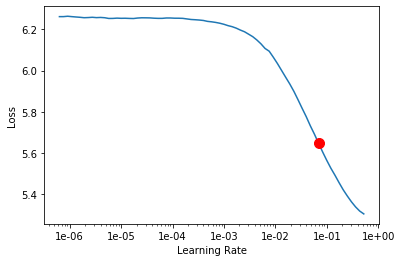

In [20]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15, suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.091588,2.882087,0.484469,08:33


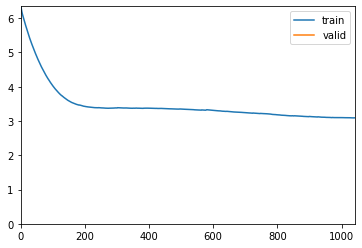

In [21]:
learn_lm.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.717507,2.634345,0.510444,09:43
1,2.587643,2.535841,0.522484,09:43
2,2.516827,2.510963,0.525960,09:44


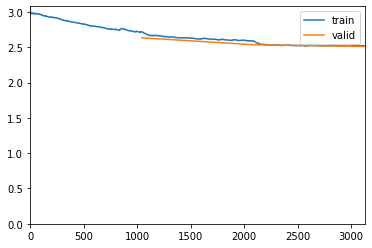

In [22]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(3, 1e-3)

Accuracy of 52.6% on the language looks pretty good.

In [23]:
learn_lm.save('lm_fine_tuned')

### Save Language Model Encoder

In [24]:
learn_lm.save_encoder('lm_ft_enc')

How good is our model? Well let's try to see what it predicts after a few given words.

In [25]:
learn_lm.load('lm_fine_tuned');

In [26]:
learn_lm.predict("Are you dumb", n_words=75, temperature=.7)

'Are you dumb or biased ? You ca n’t help , but it ’s not too late . If you ’re in the United States , it ’s clear you … https : / / t.co / DM xxbos Thanks to Bloomfield County Sheriff Jim Lawson for your quick action to protect Michiganders from the # opioidcrisis . https : / / t.co /'

In [27]:
learn_lm.predict("We are thrilled", n_words=75, temperature=.9)

'We are thrilled to hear Delaware County ’s Senior Whip , Jake Oaks , is headed to Capitol Hill for the Different Chambers … https : / / t.co / T xxbos What a wonderful weekend happy to join @senrickscott , @repsusandavis , @repdianadegette , and @sentedcruz to recognize the Thin … https : / / t.co / XXBOS Thank you to the'

In [28]:
learn_lm.predict("Hey, stupid", n_words=75, temperature=.7)

'Hey, stupid ! Go Green ! https : / / t.co / GB xxbos The # EPA is working to restore the air we breathe ! The EPA needs to hold Pruitt accountable for his unethical syst … https : / / t.co / K xxbos We know for too long that we can get things done for America . The House passed'

## Classifier

In [29]:
data_clas = load_data(path,'data_clas_export.pkl')

In [30]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=.75, callback_fns=[ShowGraph])
learn.load_encoder('lm_ft_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.45E-02


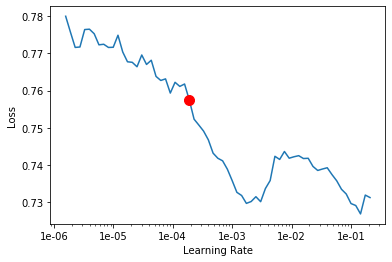

In [31]:
learn.lr_find(); learn.recorder.plot(suggestion=True, skip_start=15, skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.616818,0.577523,0.688058,03:21


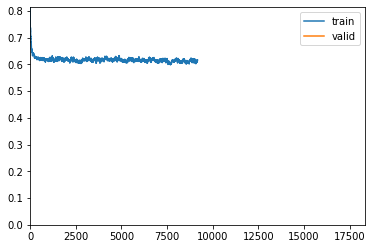

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
learn.fit_one_cycle(2, 2e-2)

In [33]:
learn.save('clas_first')

In [34]:
learn.load('clas_first');

epoch,train_loss,valid_loss,accuracy,time
0,0.549465,0.497921,0.743655,03:55
1,0.516232,0.478042,0.761096,03:58
2,0.504914,0.453791,0.774568,03:49
3,0.482227,0.433000,0.786302,03:52
4,0.473690,0.428249,0.789141,03:50


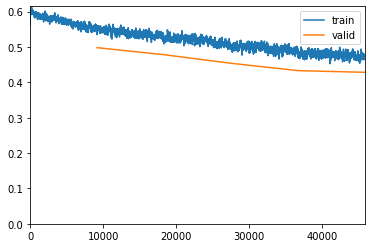

In [35]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(5e-4,1e-2))

In [36]:
learn.save('clas_second')

In [37]:
learn.load('clas_second');

epoch,train_loss,valid_loss,accuracy,time
0,0.482465,0.434172,0.781261,05:28
1,0.477079,0.473996,0.785462,05:36
2,0.462569,0.402613,0.802932,05:34
3,0.421238,0.383531,0.810378,05:41
4,0.402020,0.378288,0.814926,05:31


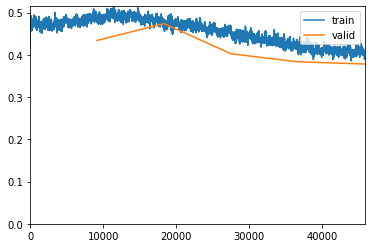

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-4,1e-2))

In [39]:
learn.save('clas_third')

In [40]:
learn.load('clas_third');

epoch,train_loss,valid_loss,accuracy,time
0,0.467329,0.419594,0.795370,06:49
1,0.460720,0.399253,0.808031,06:41
2,0.408272,0.380179,0.813536,06:45


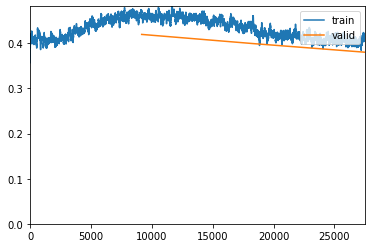

In [41]:
learn.freeze_to(-4)
learn.fit_one_cycle(3, slice(5e-4,1e-2))

In [42]:
learn.save('clas_fourth')

In [43]:
learn.load('clas_fourth');

epoch,train_loss,valid_loss,accuracy,time
0,0.433243,0.398716,0.808089,07:49
1,0.431866,0.394945,0.808002,07:48
2,0.412989,0.388726,0.815129,07:47
3,0.387194,0.363029,0.827906,07:35
4,0.353986,0.356137,0.831701,07:55


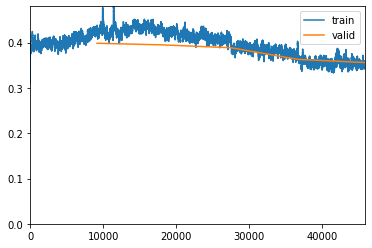

In [44]:
learn.freeze_to(-5)
learn.fit_one_cycle(5, slice(5e-4,1e-2))

In [45]:
learn.save('clas_fifth')

In [46]:
learn.load('clas_fifth');

epoch,train_loss,valid_loss,accuracy,time
0,0.365911,0.361467,0.824864,07:57
1,0.377518,0.378658,0.814695,07:38
2,0.386664,0.368163,0.821474,07:47
3,0.368350,0.356065,0.831933,07:34
4,0.339479,0.349066,0.835931,07:29
5,0.317224,0.341705,0.837351,07:53
6,0.299483,0.340684,0.839350,07:30


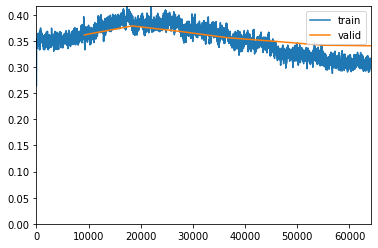

In [47]:
learn.freeze_to(-6)
learn.fit_one_cycle(7, slice(5e-4,1e-2))

In [48]:
learn.save('clas_sixth')

In [49]:
learn.load('clas_sixth');

In [98]:
learn.export('blue-or-red.pkl')

### Analyze Results

Reloading learner and data

In [9]:
learn =load_learner(path,'blue-or-red.pkl')

In [10]:
learn.data=load_data(path,'data_clas_export.pkl')

In [11]:
learn.show_results(DatasetType.Valid,rows=10)

text,target,prediction
xxbos ┳ ┻ | \n ┻ ┳ | \n ┳ ┻ | \n ┻ ┳ | \n ┳ ┻ | \n ┻ ┳ | \n ┳ ┻ | \n ┻ ┳ | \n ┳ ┻ | \n ┻ ┳ | \n ┳ ┻ | \n ┻ ┳ | \n ┳ ┻ | \n ┻ ┳ | \n,Democrat,Democrat
"xxbos xxup .@uswnt are the champions , my friends ! ! # onenationoneteam 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ 🇺 🇸 ⚽ ️ … https : / /",Democrat,Democrat
xxbos xxunk xxunk xxunk xxup xxunk xxunk xxunk ( xxunk xxunk ) xxmaj paper xxunk / xxunk xxunk xxunk / xxunk xxunk / / xxunk xxunk \n ( xxunk xxunk xxunk xxunk xxunk / / xxmaj ballots xxunk ( xxunk ( xxunk xxunk | xxunk | xxunk \ xxunk | xxunk xxunk \ xxunk | | xxunk ) / xxup now \n xxunk ),Democrat,Democrat
xxbos xxmaj who wins in the # goptaxscam ? \n xxmaj corporations 🏢 xxunk xxunk \n \n xxmaj who loses ? \n xxmaj the xxmaj middle xxmaj class 🤦 ‍ ♂ ️ 👩 ‍ 🚒 👨 ‍ 🌾 👷 👨 ‍ 🔧 👩 ‍ 🎓 👨 ‍ 💻 👩 ‍ 🏭 https : / / t.co / xxunk,Democrat,Democrat
"xxbos xxmaj met w / xxmaj lili , xxmaj malcolm , xxmaj jude , xxmaj xxunk , xxmaj benjamin , & & xxmaj rachel , leaders f / xxup ut xxmaj austin , xxup ut at xxmaj arlington , xxmaj texas xxmaj tech , & & xxmaj xxunk … https : / / t.co / xxunk",Democrat,Republican
xxbos xxmaj those bold xxmaj republicans : \n \n xxmaj amash \n xxmaj biggs \n xxmaj blum \n xxmaj brat \n xxmaj cloud \n xxmaj gaetz \n xxmaj garrett \n xxmaj gohmert \n xxmaj gosar \n xxmaj jordan \n xxmaj graves ( xxmaj louisiana ) \n xxmaj xxunk … https : / / t.co / xxunk,Republican,Republican
xxbos 📅 xxmaj weeks in xxmaj congress : 6 \n ✈ ️ xxmaj miles flown : xxunk \n xxunk ️ xxmaj miles per week : xxunk \n ✅ xxmaj votes held : 87 \n ❎ xxmaj votes per week : 14.5 \n xxunk xxmaj mi … https : / / t.co / xxunk,Democrat,Republican
"xxbos xxmaj lady xxmaj luck shines on the xxmaj las xxmaj vegas xxmaj aces ! xxmaj our xxup wnba team has back - to - back - to - back xxmaj no . 1 picks , rookie - of - the - year and … https : / / t.co / xxunk",Democrat,Democrat
xxbos xxmaj catch me xxup live on “ xxmaj person to xxmaj person ” with xxmaj michael xxmaj harris on xxup am 1230 xxmaj radio in xxmaj houston @ 11 xxup am xxup cst / 12 xxup pm xxup et . xxmaj please li … https : / / t.co / xxunk,Democrat,Democrat
"xxbos xxmaj enjoying the "" xxmaj battle of the xxmaj bay "" w / the xxup xxunk xxmaj royal xxmaj court , xxmaj student xxmaj govt . xxmaj pres . xxmaj desmond xxmaj xxunk & & xxup xxunk xxmaj president xxmaj eddie xxmaj moo … https : / / t.co / xxunk",Democrat,Democrat


#### Get predictions for the Test Set that was held back initially

In [102]:
preds = np.argmax(learn.get_preds(ds_type=DatasetType.Test, ordered=True)[0], axis=1); preds

tensor([0, 1, 0,  ..., 0, 0, 0])

In [103]:
preds_cls = ['Democrat' if p==0 else 'Republican' for p in preds]; preds_cls[:5]

['Democrat', 'Republican', 'Democrat', 'Republican', 'Democrat']

In [104]:
sum(preds_cls == ts_df['party']) / len(preds_cls)

NameError: name 'ts_df' is not defined

84% accuracy against the untouched Test Set is as good as I've gotten.

Let's run the model against specific tweets to get a feeling as to how it's performing. These tweets are recent tweets taken directly from the Twitter site.

#### Actual `realDonaldTrump` Tweets

In [115]:
learn.predict("Pray for the people in the Bahamas. Being hit like never before, Category 5.  Almost 200 MPH winds")

(Category Republican, tensor(1), tensor([0.4206, 0.5794]))

In [21]:
learn.predict("Great job by Texas Law Enforcement and First Responders in handling the terrible shooting tragedy yesterday. Thank you also to the FBI, @GregAbbott_TX and all others. A very tough and sad situation!")

(Category Republican, tensor(1), tensor([0.2310, 0.7690]))

In [22]:
learn.predict("Crazy Lawrence O’Donnell, who has been calling me wrong from even before I announced my run for the Presidency, even being previously forced by NBC to apologize, which he did while crying, for things he said about me & The Apprentice, was again forced to apologize, this time.....")

(Category Democrat, tensor(0), tensor([0.8606, 0.1394]))

In [23]:
learn.predict("We hold that legislative prayer is government speech not open to attack via those channels.” Third Circuit, Court of Appeals. “Lou, that’s why this next Election is so important, the soul of America. They want to take religion out of American lives. Thank God for judges like")

(Category Republican, tensor(1), tensor([0.3471, 0.6529]))

In [24]:
learn.predict("Wow, Report Just Out! Google manipulated from 2.6 million to 16 million votes for Hillary Clinton in 2016 Election! This was put out by a Clinton supporter, not a Trump Supporter! Google should be sued. My victory was even bigger than thought! @JudicialWatch")

(Category Republican, tensor(1), tensor([0.0249, 0.9751]))

In [25]:
learn.predict("I have not forgotten that when it was announced that I was going to do The Apprentice, and when it then became a big hit, helping NBC’s failed lineup greatly, @DebraMessing came up to me at an Upfront & profusely thanked me, even calling me “Sir.” How times have changed!")

(Category Republican, tensor(1), tensor([0.4340, 0.5660]))

In [26]:
learn.predict("“Comey and McCabe (and more) are Dirty Cops.” Joe DiGenova")

(Category Republican, tensor(1), tensor([0.4424, 0.5576]))

In [27]:
learn.predict("reports are coming. Comey very vulnerable. But where is the Supreme Court. Where is Justice Roberts? If you lie to a court, you should be held in contempt. So, if you abused the FISA, you must be held accountable. I hope Justice Roberts will take action.” Jason Chaffetz, Fox")

(Category Republican, tensor(1), tensor([0.3196, 0.6804]))

In [28]:
learn.predict("James Comey has been rebuked at the highest level, with much more to come. An IG Report doesn’t get any stronger, calling him dangerous, insubordinate. THANK GOODNESS THAT DONALD TRUMP WAS ELECTED, BECAUSE IF HE WASN’T ELECTED, THESE PEOPLE WOULD STILL BE IN POWER. Two more.....")

(Category Democrat, tensor(0), tensor([0.5482, 0.4518]))

In [29]:
learn.predict("...is about American Freedom. Redirect the supply chain. There is no reason to buy everything from China!")

(Category Republican, tensor(1), tensor([0.1640, 0.8360]))

In [30]:
learn.predict("Peter Morici, Economist: Tariffs will not impact American consumers that much because the Chinese currency has gone down, which gives our importers a discount. Importers can find suppliers outside of China. Absolutely worth it, we don’t want to be servants to the Chinese! This...")

(Category Democrat, tensor(0), tensor([0.5469, 0.4531]))

In [31]:
learn.predict("“The vindication belongs to the President for firing James Comey. It was clearly the right thing to do. You don’t want an FBI Director with Jim Comey’s ethics.” Jason Riley, Wall Street Journal")

(Category Democrat, tensor(0), tensor([0.5036, 0.4964]))

In [32]:
learn.predict("Enjoy the low gas prices over the Labor Day weekend! My energy policies have made America energy independent while keeping prices low, just like a Tax Cut. The Democrats “green” policies will raise your price of gas!")

(Category Republican, tensor(1), tensor([0.0229, 0.9771]))

In [33]:
learn.predict("....but now we are moving forward like never before. We are winning again, and we are respected again!")

(Category Republican, tensor(1), tensor([0.2846, 0.7154]))

In [34]:
learn.predict("Being scolded by failed former “Intelligence” officials, like James Clapper, on my condolences to Iran on their failed Rocket launch. Sadly for the United States, guys like him, Comey, and the even dumber John Brennan, don’t have a clue. They really set our Country back,....")

(Category Republican, tensor(1), tensor([0.1849, 0.8151]))

In [35]:
learn.predict("Just watched Congresswoman Debbie Dingell, and many other Democrats, wanting to give up on our very successful Trade battle with China, which has had its worst Economic year in memory (and getting worse). We are taking in $Billions. Will be big for Farmers and ALL!")

(Category Republican, tensor(1), tensor([0.4021, 0.5979]))

In [36]:
learn.predict("Has anyone noticed that the top shows on @foxnews and cable ratings are those that are Fair (or great) to your favorite President, me! Congratulations to @seanhannity for being the number one show on Cable Television!")

(Category Republican, tensor(1), tensor([0.0308, 0.9692]))

In [37]:
learn.predict("Looking like our great South Carolina could get hit MUCH harder than first thought. Georgia and North Carolina also. It’s moving around and very hard to predict, except that it is one of the biggest and strongest (and really wide) that we have seen in decades. Be safe!")

(Category Republican, tensor(1), tensor([0.2664, 0.7336]))

In [38]:
learn.predict("MAKE AMERICA GREAT AGAIN, which is happening, and then, KEEP AMERICA GREAT!")

(Category Republican, tensor(1), tensor([0.1817, 0.8183]))

In [39]:
learn.predict("...Yes, I am currently suing various people for violating their confidentiality agreements. Disgusting and foul mouthed Omarosa is one. I gave her every break, despite the fact that she was despised by everyone, and she went for some cheap money from a book. Numerous others also!")

(Category Democrat, tensor(0), tensor([0.6841, 0.3159]))

realDonaldTrump Accuracy: 15/20 = 75%

#### Actual `HillaryClinton` Tweets

In [40]:
learn.predict("Republican officials across the country have used gerrymandering to choose their voters rather than letting voters choose their representatives.")

(Category Democrat, tensor(0), tensor([0.9828, 0.0172]))

In [41]:
learn.predict("This is a great way to help fight the fires in the Amazon. One hundred percent of donations go to partners working on the ground")

(Category Democrat, tensor(0), tensor([0.7166, 0.2834]))

In [42]:
learn.predict("The passage of the 19th Amendment was just the first step on the road to ensure all American women can exercise their right to vote. On #WomensEqualityDay, let's celebrate how far we've come and resolve to keep marching. #EqualityCantWai")

(Category Democrat, tensor(0), tensor([0.9438, 0.0562]))

In [43]:
learn.predict("Meet 55 amazing candidates @runforsomething has endorsed this month, including an activist who helped remove Confederate statues in Memphis and a lifelong education advocate")

(Category Democrat, tensor(0), tensor([0.9370, 0.0630]))

In [44]:
learn.predict("Adele's grandfather built her family's home after he returned to St. John from World War II—and she won't give up on it. Neither can we.")

(Category Democrat, tensor(0), tensor([0.9040, 0.0960]))

In [45]:
learn.predict("BREAKING: In its latest attack on immigrant communities, the Trump administration is moving to dismantle the ONLY established protections for children in government custody. We can't let this happen, here’s why")

(Category Democrat, tensor(0), tensor([0.9549, 0.0451]))

In [46]:
learn.predict("In the last 24 hours, the administration has announced: - They will seek the power to detain migrant children indefinitely - They won’t provide flu shots to families in detention Six children have already died, three in part from the flu. This is a recipe for more tragedy.")

(Category Democrat, tensor(0), tensor([0.9794, 0.0206]))

In [47]:
learn.predict("The debunked study you’re referring to was based on 21 undecided voters. For context that’s about half the number of people associated with your campaign who have been indicted.")

(Category Democrat, tensor(0), tensor([0.6827, 0.3173]))

In [48]:
learn.predict("What democracy and peaceful protest look like: 1.7 million people marching yesterday in Hong Kong's Victoria Park.")

(Category Democrat, tensor(0), tensor([0.5879, 0.4121]))

In [49]:
learn.predict("Happy birthday, @BillClinton! You can sign his card here")

(Category Republican, tensor(1), tensor([0.2409, 0.7591]))

In [50]:
learn.predict("Asked why she persisted in the fight for women’s suffrage, ratified August 18, 1920, Alice Paul said: “When you put your hand to the plow, you can’t put it down until you get to the end of the row.” With thanks to our forebears for all they've fought for, the work continues")

(Category Democrat, tensor(0), tensor([0.8441, 0.1559]))

In [51]:
learn.predict("Russia’s interference in our elections will continue to threaten our democracy until Republicans join Democrats to stop it.")

(Category Democrat, tensor(0), tensor([0.8705, 0.1295]))

In [52]:
learn.predict("It should be a given in America that every citizen has free and fair access to the ballot box. Right now, it simply isn't. ")

(Category Democrat, tensor(0), tensor([0.8562, 0.1438]))

In [53]:
learn.predict("Two years ago in Charlottesville, a neo-Nazi drove a car into a crowd of people protesting white supremacy and killed Heather Heyer. May we honor her memory by speaking out against hatred, as she did, and working together to defeat it.")

(Category Democrat, tensor(0), tensor([0.8977, 0.1023]))

In [54]:
learn.predict("May we all stand in solidarity with the people of Hong Kong as they speak out for democracy, freedom from repression, and a world they long to see")

(Category Republican, tensor(1), tensor([0.4145, 0.5855]))

In [55]:
learn.predict("If you're heartsick over the images and videos of children in Mississippi whose parents were taken away by ICE, pitch in or spread the word to fund organizations that are providing legal aid and support services to impacted familie")

(Category Democrat, tensor(0), tensor([0.6563, 0.3437]))

In [56]:
learn.predict("Heading into next year’s elections, every voter must reckon with what their vote supports. At the border and around the country, a vote for Trump is a vote to tear parents away from their children.")

(Category Democrat, tensor(0), tensor([0.9902, 0.0098]))

In [57]:
learn.predict("The honor is ours; it’s not every day you meet a queen. 👑")

(Category Democrat, tensor(0), tensor([0.7874, 0.2126]))

In [58]:
learn.predict("'If there is a book that you want to read but it hasn't been written yet, you must be the one to write it,' Toni Morrison said. We are all so lucky to live in a world where she took her own advice and shared it with others.")

(Category Democrat, tensor(0), tensor([0.9829, 0.0171]))

In [59]:
learn.predict("@ChelseaClinton and I are thrilled to announce 'The Book of Gutsy Women,' out October 1st. It's a conversation about over 100 women who have inspired us—and narrowing it down was a process! ")

(Category Democrat, tensor(0), tensor([0.9896, 0.0104]))

In [60]:
learn.predict("People suffer from mental illness in every other country on earth; people play video games in virtually every other country on earth. The difference is the guns.")

(Category Democrat, tensor(0), tensor([0.8539, 0.1461]))

HillaryClinton Accuracy: 18/20 = 90%

#### Actual `BernieSanders` Tweets

In [61]:
learn.predict("Nobody wants to look their grandchild in the eye 30 years from now and have them say, “You knew what the scientists were saying in 2019 and you didn’t do anything.”")

(Category Democrat, tensor(0), tensor([0.5906, 0.4094]))

In [62]:
learn.predict("Coal miners are not my enemy. The men and women who work on oil rigs are not my enemy. Climate change is my enemy. #ClimateTownHall")

(Category Democrat, tensor(0), tensor([0.7114, 0.2886]))

In [63]:
learn.predict("""How we fund the #GreenNewDeal:

-Hold the fossil fuel industry accountable
-Revenue from wholesale of renewable energy
-Eliminate federal fossil fuel subsidies
-Scale back military spending
-Tax revenue from 20 million jobs
-Make the wealthy pay their fair share""")

(Category Democrat, tensor(0), tensor([0.8305, 0.1695]))

In [64]:
learn.predict("Maybe, just maybe, instead of spending more than $1.5 trillion a year on weapons of destruction to kill each other, nations around the world can work together against our common enemy of climate change.")

(Category Democrat, tensor(0), tensor([0.8043, 0.1957]))

In [65]:
learn.predict("'Safe fracking' is like 'clean coal'—it doesn't exist. We need to ban fracking in America.")

(Category Republican, tensor(1), tensor([0.4080, 0.5920]))

In [66]:
learn.predict("We have a corporate health care system that bankrupts hundreds of thousands of people for getting sick. That is barbaric!")

(Category Democrat, tensor(0), tensor([0.7407, 0.2593]))

In [67]:
learn.predict("""The climate crisis is our greatest challenge — and our single greatest opportunity to build a just and equitable future.

We're going to pass a Green New Deal and create 20 million good-paying """)

(Category Democrat, tensor(0), tensor([0.9537, 0.0463]))

#### Actual `SenatorDurbin` Tweets

In [68]:
learn.predict("""Today I visited 
@Autismsi
 to learn more about their work in providing services to those on the autism spectrum. As a member of the Senate Appropriations Committee, I will continue to fight for federal funding for autism research.""")

(Category Democrat, tensor(0), tensor([0.6434, 0.3566]))

In [69]:
learn.predict("""And now we learn that the President is re-routing $771M from construction projects to defend our European allies from Russian aggression, right after cancelling $250M in aid to the Ukraine for that very same purpose. Gen. Mattis is right - we need to put our allies over politics.""")

(Category Republican, tensor(1), tensor([0.3435, 0.6565]))

In [70]:
learn.predict("""If the President thinks that Congress is going to turn around and provide additional money for any of the defunded projects, he's sorely mistaken. These funds were already appropriated as intended. We cannot ask the American people to foot the bill twice for his vanity project.""")

(Category Democrat, tensor(0), tensor([0.9803, 0.0197]))

In [71]:
learn.predict("""I remember when Mexico was going to pay for President Trump's border wall. He failed entirely to fulfill that promise and has now decided to steal funding from our armed service members and their families instead. Over 120 military projects are going to lose funding as a result.""")

(Category Democrat, tensor(0), tensor([0.9645, 0.0355]))

In [72]:
learn.predict("""This is why I introduced the bipartisan Rural America Health Corps Act, which will expand upon the current 
@NHSCorps
 program to provide new, directed loan forgiveness funding for rural health providers who serve in rural communities.""")

(Category Democrat, tensor(0), tensor([0.5187, 0.4813]))

In [73]:
learn.predict("""The 
@NHSCorps
 has a program that provides loan forgiveness for medical professionals who work in health professional shortage areas, but only 30% of the program participants serve in rural communities.""")

(Category Democrat, tensor(0), tensor([0.6348, 0.3652]))

#### Actual `RandPaul` Tweets

In [74]:
learn.predict("""I hope you'll join us September 5th at the 2019 Service Academy Information Fair and you can apply for an academy nomination on our website here""")

(Category Republican, tensor(1), tensor([0.3685, 0.6315]))

In [75]:
learn.predict("""“What do Panamanian frogs, an abandoned Civil War-era mental hospital, and the Pakistani film industry have in common? Your tax dollars were spent to support each of them.”""")

(Category Republican, tensor(1), tensor([0.3248, 0.6752]))

In [76]:
learn.predict("""It’s interesting several of the U.S. Senators now wanting to travel to Russia voted against allowing Russian legislators to travel to the United States. 
@realDonaldTrump
 is right to want diplomacy.""")

(Category Democrat, tensor(0), tensor([0.5694, 0.4306]))

In [77]:
learn.predict("""The topics touched on during the roundtable prove how appropriately organizing the event allowed the local community’s real problems, strengths and desires to take center stage.""")

(Category Democrat, tensor(0), tensor([0.5225, 0.4775]))

In [78]:
learn.predict("""RIP to a man who lived a life of liberty, peace and philanthropy. Great blessings being great responsibility, and David Koch lived that way. His many contributions will have lasting impact on our country. My thoughts are with his family today.""")

(Category Democrat, tensor(0), tensor([0.5065, 0.4935]))

In [79]:
learn.predict("""Congratulations to Bowling Green East on their win against Australia at Little League World Series!""")

(Category Republican, tensor(1), tensor([0.0675, 0.9325]))

In [80]:
learn.predict("""Obama got a Nobel Peace Prize and subsequently sent 100,000 US troops to ramp up war in Afghanistan. If 
@realDonaldTrump
 ends the war, the Nobel Committee should retrieve Obama’s peace prize and give it to Trump!
""")

(Category Democrat, tensor(0), tensor([0.9259, 0.0741]))

In [81]:
learn.predict("""Today I joined 
@FoxNews
 with my wife 
@KelleyAshbyPaul
 to discuss my surgery and recovery. Watch the full interview here: https://youtu.be/oIkSoo68JGM""")

(Category Republican, tensor(1), tensor([0.1844, 0.8156]))

In [82]:
learn.predict("""I have proposed spending cut after spending cut. When will congress stop the reckless spending?""")

(Category Republican, tensor(1), tensor([0.0214, 0.9786]))

In [83]:
learn.predict("""I have and will continue to fight to cut spending. This is out of control.""")

(Category Republican, tensor(1), tensor([0.0296, 0.9704]))

In [84]:
learn.predict("""Great to see so many friendly faces at my first public event since my surgery! I was in Williamsburg, KY today for the Southern KY Chamber of Commerce luncheon and enjoyed speaking and taking questions from those in attendance""")

(Category Republican, tensor(1), tensor([0.2291, 0.7709]))

### Ideology Score

Govtrack, https://www.govtrack.us/congress/members/report-cards/2018/senate/ideology calculates an `ideology` score for each member of congress. This is an attempt to rank the conservative/liberal ideology of the lawmaker. It is determined by a number factors, including the type of laws the legislator has supported. The `ideology` score ranges from 1 and 0, with 1 being the most ideologically conservative and 0 being the most liberal.

Rather than just using the blue-or-red model to classify a tweet as being from a Democratic or Republican lawmaker, would it be possible to analyze a large number of tweets at once and obtain a proxy for the expert `ideology` score calculated by Govtrack?

The general approach is to look at many tweets from a specific member of congress, classify each tweet as being Democratic or Republican and then calculate an average. By their nature, tweets are short and may be too generic to provide much ideological 'signal'. (Though having said this, 84% accuracy for any individual tweet seems pretty good.) None-the-less, an average should cancel out the 'noise' and increase the 'signal'.

The `ideology_score` function takes a previously trained model, a tweet csv_file for a specific member of congress and returns two averages. The first is the accuracy of the classifications, i.e., what percentage of the tweets were classified as Republican. The second average is of the probabilities of each tweet being Republican. In both cases, the averages are normalized so as to be consistent with the `ideology` score provided by Govtrack, namely, the averages closer to 1 are more Republican and closer to 0 more Democratic. Additionally, the ground-truth of which party the lawmaker is a member is returned as well as the number of tweets classified.

In [116]:
def blue_red_scrore(path, learner, csv_file, col_text='text', col_party='party'):
    df = pd.read_csv(csv_file)
    try:
        party = df[col_party][1]
    except:
        party = np.nan
    test = TextList.from_csv(path, csv_file, col_text)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test, ordered=True)[0]
    d,r =  (sum(preds)/len(preds)).numpy().tolist()
    clas = np.argmax(preds, axis=1)
    clas = int(sum(clas))/len(preds)
    return [round(clas,2), round(r,2), party, len(df[col_text]) ]

Hillary and Trump Ideology Score

In [86]:
blue_red_scrore(path, learn, path/'../clinton-trump-tweets/orig_tweets/realDonaldTrump.csv')

[0.68, 0.61, nan, 2161]

In [87]:
blue_red_scrore(path, learn, path/'../clinton-trump-tweets/orig_tweets/hillaryclinton.csv')

[0.19, 0.26, nan, 2605]

Conservative Republicans (as determined by the GovTrack ideology score)

In [235]:
blue_red_scrore(path, learn, path/'data_full/McConnellPress.csv')

[0.98, 0.92, 'Republican', 1451]

In [236]:
blue_red_scrore(path, learn, path/'data_full/InhofePress.csv')

[0.97, 0.94, 'Republican', 1552]

In [237]:
blue_red_scrore(path, learn, path/'data_full/SenatorEnzi.csv')

[0.9, 0.82, 'Republican', 1712]

In [238]:
blue_red_scrore(path, learn, path/'data_full/SenTomCotton.csv')

[0.93, 0.85, 'Republican', 1928]

In [239]:
blue_red_scrore(path, learn, path/'data_full/SenatorRounds.csv')

[0.93, 0.85, 'Republican', 1813]

In [240]:
blue_red_scrore(path, learn, path/'data_full/JohnCornyn.csv')

[0.76, 0.69, 'Republican', 1144]

In [241]:
blue_red_scrore(path, learn, path/'data_full/sendavidperdue.csv')

[0.88, 0.82, 'Republican', 1637]

In [242]:
blue_red_scrore(path, learn, path/'data_full/SenPatRoberts.csv')

[0.95, 0.85, 'Republican', 1080]

Centrist Republicans

In [243]:
blue_red_scrore(path, learn, path/'data_full/SenatorBurr.csv')

[0.86, 0.77, 'Republican', 1736]

In [244]:
blue_red_scrore(path, learn, path/'data_full/RandPaul.csv')

[0.75, 0.69, 'Republican', 1360]

In [245]:
blue_red_scrore(path, learn, path/'data_full/SenShelby.csv')

[0.95, 0.87, 'Republican', 1680]

In [246]:
blue_red_scrore(path, learn, path/'data_full/SenRobPortman.csv')

[0.86, 0.77, 'Republican', 1990]

In [247]:
blue_red_scrore(path, learn, path/'data_full/LisaMurkowski.csv')

[0.77, 0.72, 'Republican', 1943]

In [248]:
blue_red_scrore(path, learn, path/'data_full/SenatorCollins.csv')

[0.72, 0.7, 'Republican', 1857]

Centrist Democrats

In [249]:
blue_red_scrore(path, learn, path/'data_full/Sen_JoeManchin.csv')

[0.29, 0.34, 'Democrat', 1894]

In [250]:
blue_red_scrore(path, learn, path/'data_full/SenatorTester.csv')

[0.23, 0.29, 'Democrat', 1468]

In [251]:
blue_red_scrore(path, learn, path/'data_full/sendougjones.csv')

[0.32, 0.36, 'Democrat', 815]

In [252]:
blue_red_scrore(path, learn, path/'data_full/MarkWarner.csv')

[0.14, 0.22, 'Democrat', 1364]

In [253]:
blue_red_scrore(path, learn, path/'data_full/ChrisCoons.csv')

[0.14, 0.22, 'Democrat', 1698]

In [254]:
blue_red_scrore(path, learn, path/'data_full/SenatorBennet.csv')

[0.16, 0.22, 'Democrat', 1857]

Liberal Democrats

In [255]:
blue_red_scrore(path, learn, path/'data_full/SenWarren.csv')

[0.04, 0.1, 'Democrat', 1808]

In [256]:
blue_red_scrore(path, learn, path/'data_full/SenMarkey.csv')

[0.08, 0.15, 'Democrat', 1472]

In [257]:
blue_red_scrore(path, learn, path/'data_full/SenKamalaHarris.csv')

[0.03, 0.1, 'Democrat', 1878]

In [258]:
blue_red_scrore(path, learn, path/'data_full/SenJeffMerkley.csv')

[0.06, 0.12, 'Democrat', 1515]

In [259]:
blue_red_scrore(path, learn, path/'data_full/SenSanders.csv')

[0.05, 0.12, 'Democrat', 1631]

In [117]:
blue_red_scrore(path, learn, path/'data_full/GillibrandNY.csv')

[0.05, 0.13, 'Democrat', 535]

### Ideological Scores of Members of Congress

In [373]:
#Calculate all ideology scores contained in "data_full/" and save as "data_ful.csv"
# ! ipython ideology_scores.py

In [358]:
df = pd.read_csv("data_full.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816db16cf8>]], dtype=object)

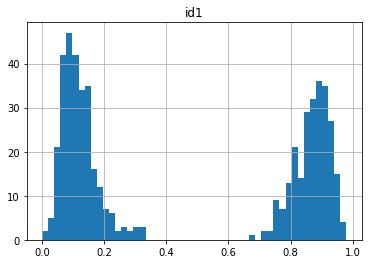

In [372]:
df.hist("id1",bins=50)

### 0=Most Democratic and 1=Most Republican

### Ideological Scores of Media Organizations

https://www.quora.com/Which-media-outlets-in-the-USA-are-right-wing-and-which-are-left-wing

In [375]:
df = pd.read_csv("data_media.csv")

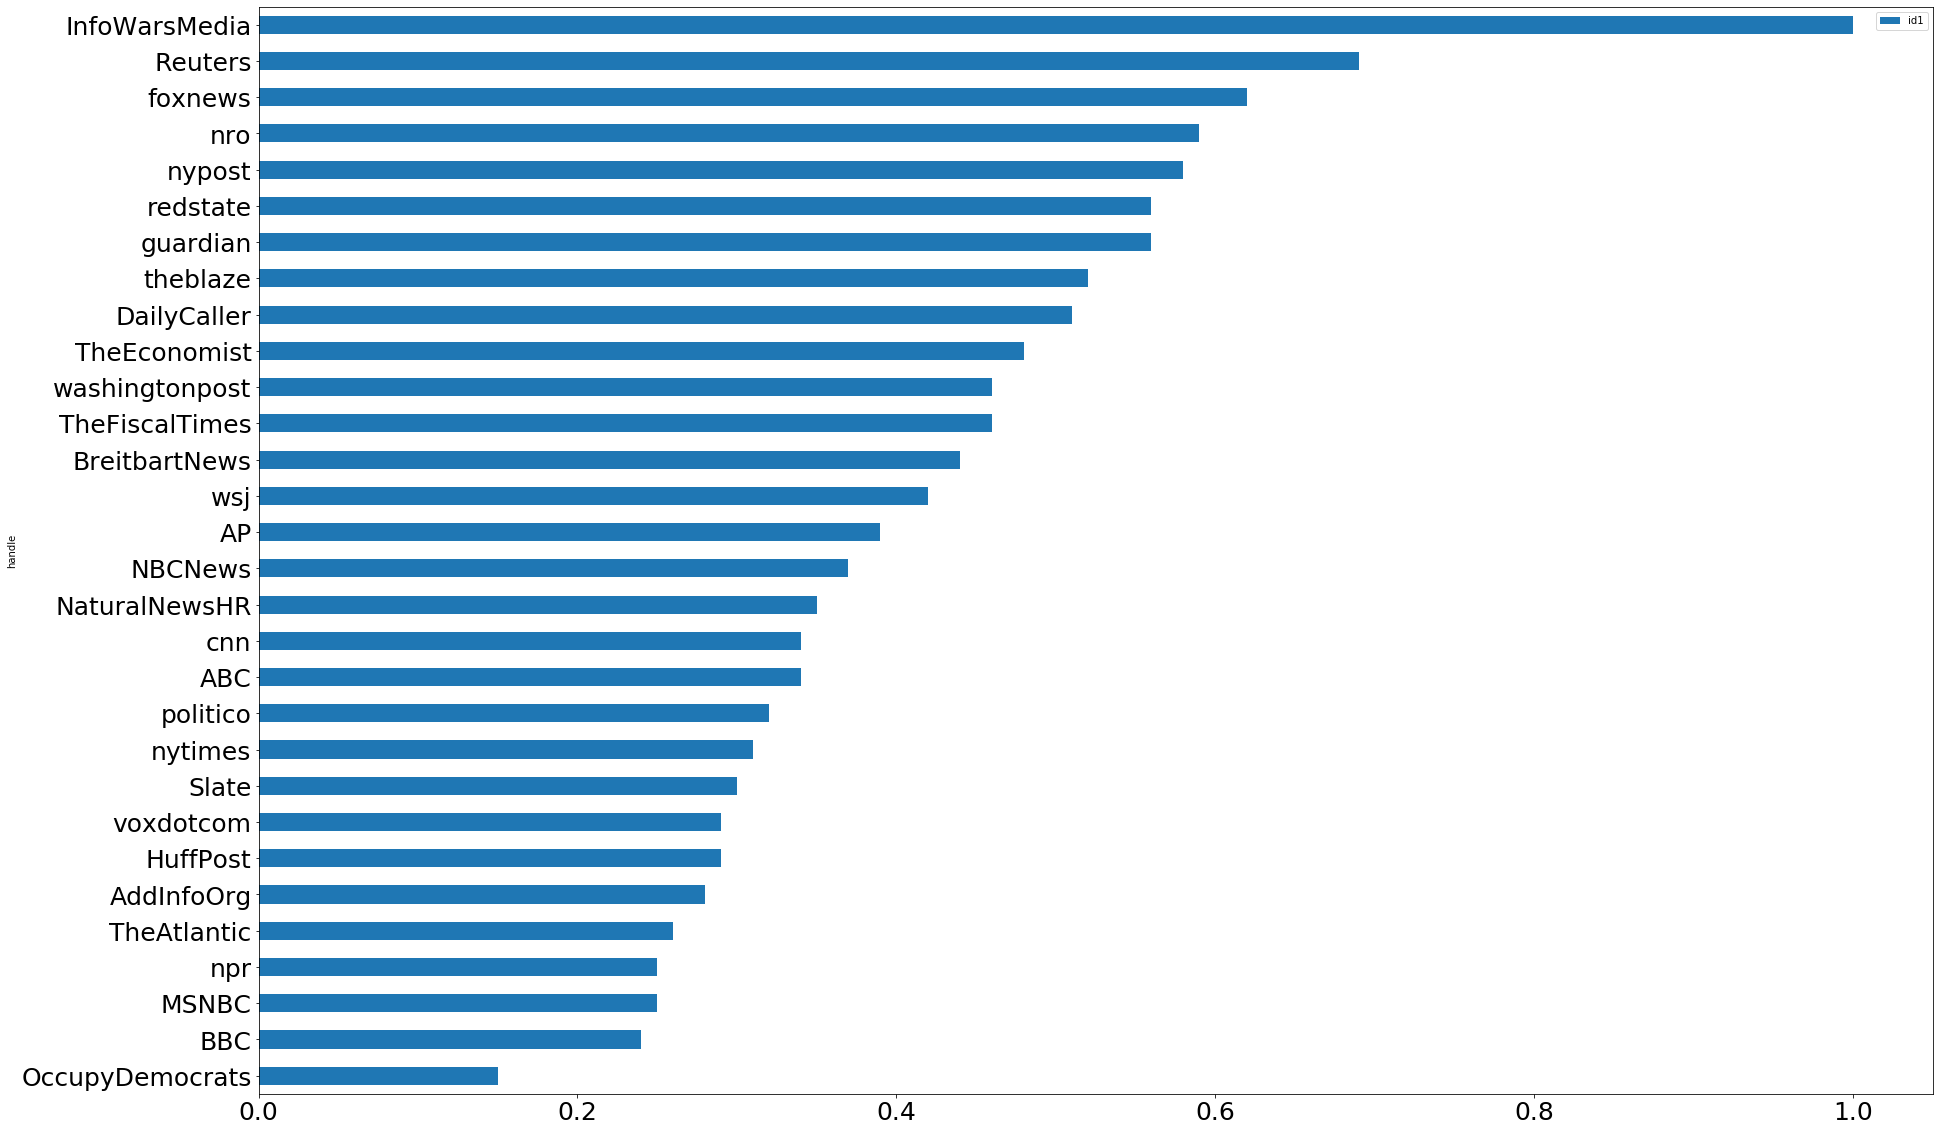

In [398]:
df.plot.barh(y='id1',x='handle',figsize=(30,20),fontsize=25)

### Ideology Score of Large Banks

#### 0 is progressive, 1 is conservative

In [109]:
df = pd.read_csv("data_banks.csv")

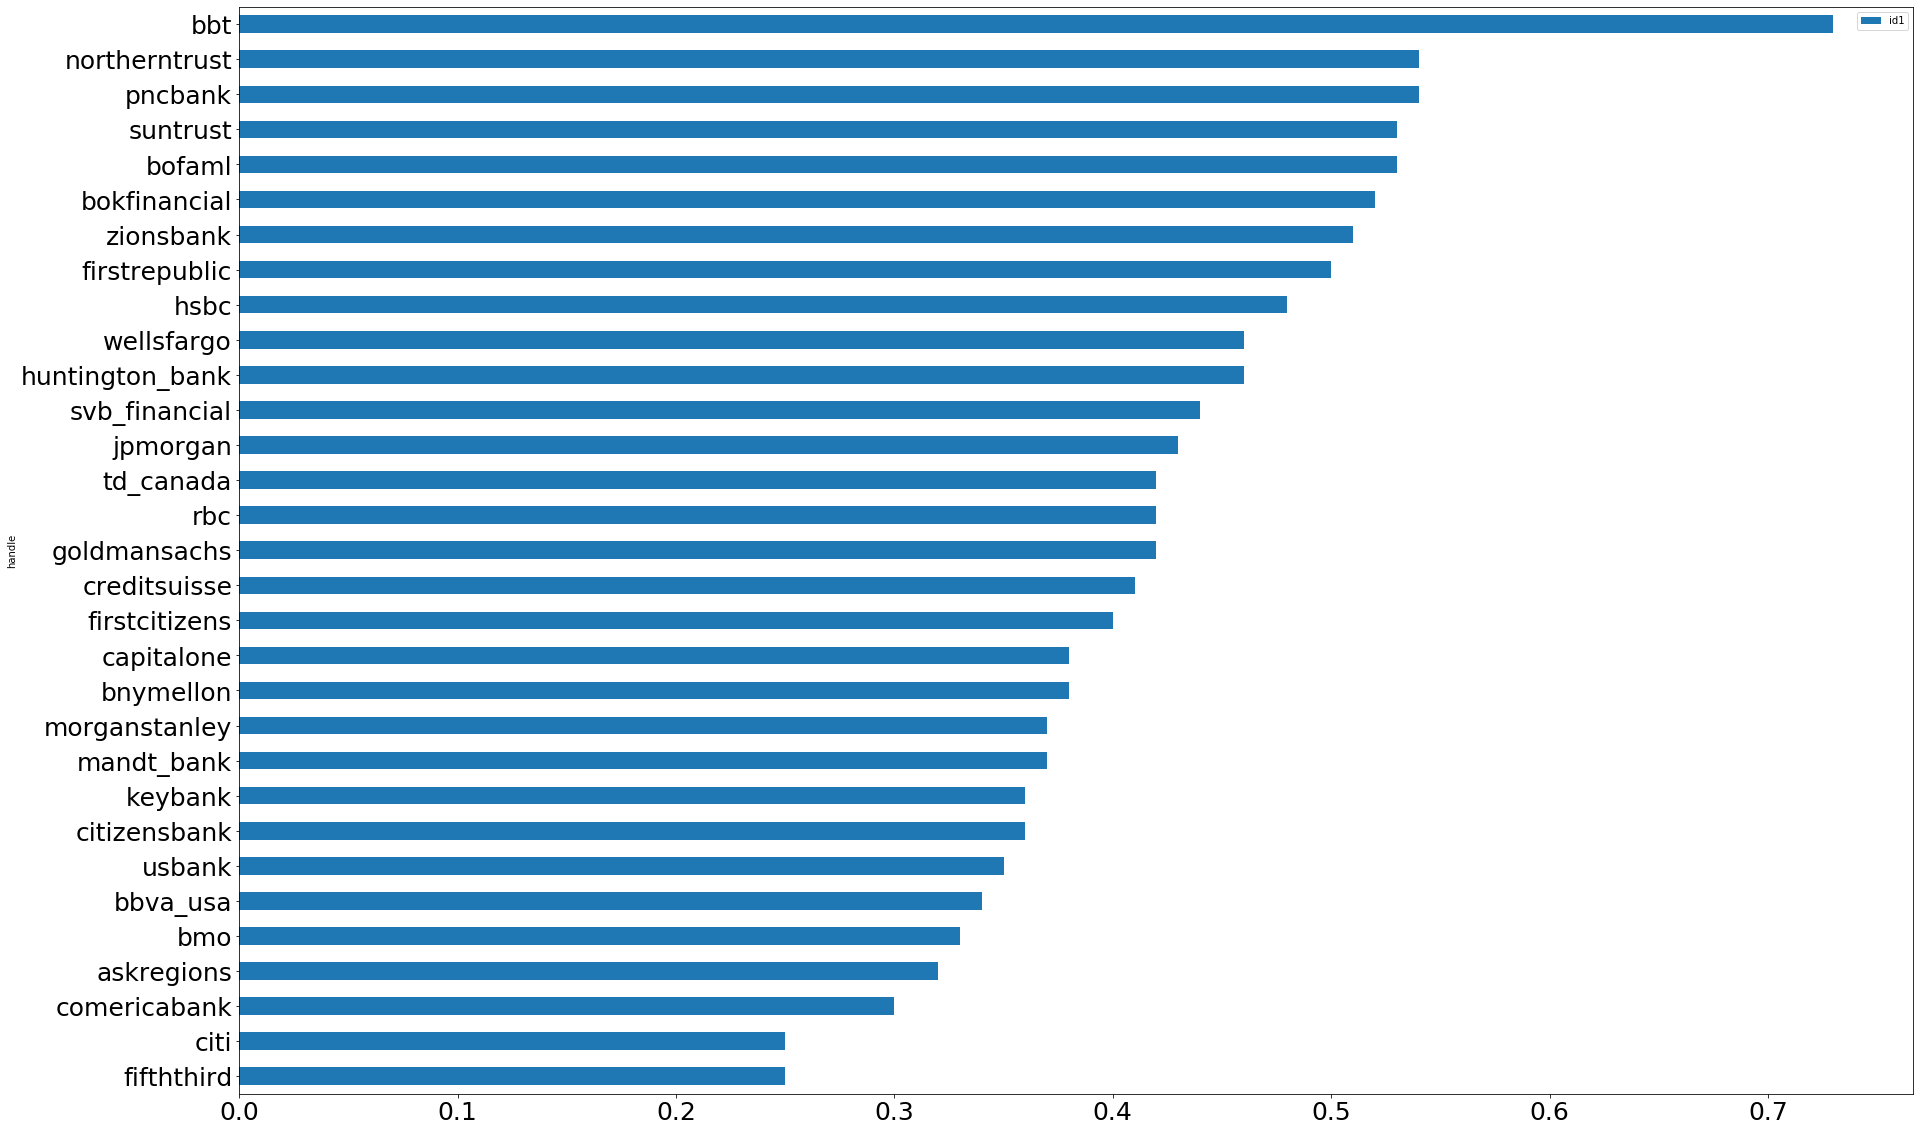

In [110]:
df.plot.barh(y='id1',x='handle',figsize=(30,20),fontsize=25)